# Lesson 0023 - MNIST Classification Convolutional Neural Network (VI)
In this lesson, we steal the code from [lesson 0022](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0022_mnist_classification_convolutional_neural_network_5.ipynb) to create a convolutional neural network with $2$ convolutional layers of $512$ filters each.<br>
We then introduce a __dropout__ layer.<br>
We apply this model on the MNIST data set.

In [1]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [2]:
( train_x, train_y ),( test_x, test_y ) = tf.keras.datasets.mnist.load_data()

In [3]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [4]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


In [5]:
mu = np.mean( train_x )

sigma = np.std( train_x )



train_x = ( train_x - mu ) / sigma

test_x = ( test_x - mu ) / sigma

In [6]:
train_y_2 = np.zeros( shape = [ 60000, 10 ] )

test_y_2 = np.zeros( shape = [ 10000, 10 ] )




for i in range( 60000 ):
    
    train_y_2[ i, train_y[ i ] ] = 1.0
    
    
for i in range( 10000 ):
    
    test_y_2[ i, test_y[ i ] ] = 1.0
    




train_y = train_y_2

test_y = test_y_2

Up until now, we stole code from [lesson 0022](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0022_mnist_classification_convolutional_neural_network_5.ipynb).<br>
Now, we extend the approach from  [lesson 0022](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0022_mnist_classification_convolutional_neural_network_5.ipynb) by introducing a __dropout__ layer.<br>
The idea of __dropout__ is, that we take a layer in our neural network, and we set the output of a certain fraction of randomly selected nodes in that layer to $0$ during training.<br>
Now consider you have the nodes $N_{1}, N_{2}, \dots, N_{k}$. And consider, that these nodes feed into the next layer $L$. If you randomly force the output of a subset of the nodes $N_{1}, N_{2}, \dots$ to $0$, then the other nodes must feed sufficient data into $L$, so that $L$ can learn the data. If you randomly turn off nodes from $N_{1}, N_{2}, \dots$, then you actually train several models in parallel, where each model is one configuration with a certain subset of the $N_{1}, N_{2}, \dots$ turned off. This forces $L$ to train a very general model, and this results in a model which generalizes better.<br>
In order to introduce __dropout__ we use [dropout](https://www.tensorflow.org/api_docs/python/tf/layers/dropout) and also we introduce a placeholder __dropout_rate__.

In [7]:
x_tf = tf.placeholder( tf.float32, shape = [ None, 28, 28, 1 ] )

y_tf = tf.placeholder( tf.float32, shape = [ None, 10 ] )

dropout_rate = tf.placeholder( tf.float32 )




conv1 = tf.layers.conv2d( x_tf, filters = 512, kernel_size = [ 5, 5 ], name = 'conv1' )

max1 = tf.layers.max_pooling2d( conv1, pool_size = [ 2, 2 ], strides = [ 2, 2 ] )

conv2 = tf.layers.conv2d( max1, filters = 512, kernel_size = [ 5, 5 ] )

max2 = tf.layers.max_pooling2d( conv2, pool_size = [ 2, 2 ], strides = [ 2, 2 ])

flat = tf.layers.flatten( max2 )

dropout = tf.layers.dropout( flat, rate = dropout_rate )





W_tf = tf.Variable( tf.truncated_normal( [ 8192, 10 ] ) )

b_tf = tf.Variable( tf.truncated_normal( [ 10 ] ) )

output = tf.nn.leaky_relu( tf.matmul( dropout, W_tf ) + b_tf )




cross_entropy = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2( logits = output, labels = y_tf ) )




gd = tf.train.GradientDescentOptimizer( 0.001 ).minimize( cross_entropy )



hit = tf.equal( tf.argmax( output, 1 ), tf.argmax( y_tf, 1 ) )



accuracy = 100 * tf.reduce_mean( tf.cast( hit, tf.float32 ) )

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dropout instead.


In [8]:
config = tf.ConfigProto()

config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

We train this model with a learning rate of $0.001$ for $200000$ iterations on $100$ randomly selected training data.<br>
For this, we steal code from [lesson 0022](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0022_mnist_classification_convolutional_neural_network_5.ipynb).<br>
During training, we set the __dropout_rate__ to $0.5$, during evaluation, we set it to $0$.

In [9]:
progress_train = []

progress_train_current = []

progress_test = []

progress_iterations = []

test_performance_buffer = []

train_performance_buffer = []






train_x_r = np.reshape( train_x, newshape = [ 60000, 28, 28, 1 ] )

test_x_r = np.reshape( test_x, newshape = [ 10000, 28, 28, 1 ] )
 
    
    
sess.run( tf.global_variables_initializer() )
        
for i in range( 200000 ):
                
    random_integers = np.random.choice( range( 60000 ), 100, replace = False )
                
    local_x = train_x[ random_integers, :, : ]
    
    local_y = train_y[ random_integers, : ]
    
    local_x = np.reshape( local_x, newshape = [ 100,28, 28, 1 ] )
        
    sess.run( gd, feed_dict = { x_tf : local_x, y_tf : local_y, dropout_rate : 0.5 } )
    
    if( ( i % 100 ) == 0 ):
        
        for j in range(60):
            
            train_performance_buffer.append( 
                sess.run( accuracy, feed_dict = { x_tf : train_x_r[ ( j * 1000 ) : ( ( j + 1 ) * 1000 ), :, :, : ],
                                                 y_tf : train_y[ ( j * 1000 ) : ( ( j + 1 ) * 1000 ), : ], 
                                                dropout_rate : 0.0 } ) )
            
        progress_train.append( np.mean( train_performance_buffer ) )
        
        train_performance_buffer = []
        
        for j in range(10):
            
            test_performance_buffer.append( 
                sess.run( accuracy, feed_dict = { x_tf : test_x_r[ ( j * 1000 ) : ( ( j + 1 ) * 1000 ), :, :, : ],
                                                 y_tf : test_y[ ( j * 1000 ) : ( ( j + 1 ) * 1000 ), : ],
                                                dropout_rate : 0.0 } ) )
            
        progress_test.append( np.mean( test_performance_buffer ) )
        
        test_performance_buffer = []
        
        progress_train_current.append( sess.run( accuracy, feed_dict = { x_tf : local_x, y_tf : local_y, 
                                                                        dropout_rate : 0.0 } ) )
        
        progress_iterations.append( i )

Text(0, 0.5, 'Accuracy (%)')

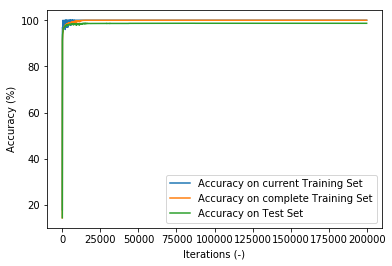

In [10]:
plt.plot( progress_iterations, progress_train_current, label = 'Accuracy on current Training Set' )

plt.plot( progress_iterations, progress_train, label = 'Accuracy on complete Training Set' )

plt.plot( progress_iterations, progress_test, label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

Text(0, 0.5, 'Accuracy (%)')

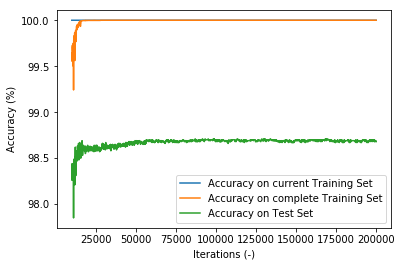

In [11]:
plt.plot( progress_iterations[ 100 : 2000 ], progress_train_current[ 100 : 2000 ], 
         label = 'Accuracy on current Training Set' )

plt.plot( progress_iterations[ 100 : 2000 ], progress_train[ 100 : 2000 ], label = 'Accuracy on complete Training Set' )

plt.plot( progress_iterations[ 100 : 2000 ], progress_test[ 100 : 2000 ], label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

Text(0, 0.5, 'Accuracy (%)')

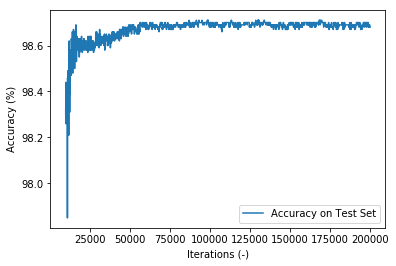

In [12]:
plt.plot( progress_iterations[ 100 : 2000 ], progress_test[ 100 : 2000 ], label= 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'Accuracy (%)' )

In [13]:
saver = tf.train.Saver()

saver.save( sess, 
           "C:\\Users\\rhopi\\OneDrive\\Desktop\\python dev\\github\\lesson_0023\\model\\convolutional_neural_network_512_512_dropout" )

sess.close()

Due to the __dropout__, this model performs slightly better on the test set than the model from [lesson 0022](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0022_mnist_classification_convolutional_neural_network_5.ipynb).<br>
On my machine, this model and the model from [lesson 0022](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0022_mnist_classification_convolutional_neural_network_5.ipynb) train for approximately $6$ hours with a __RTX 2080__, that's why in the next lesson, we will try another architecture.<br>
From this architecture, we learn, that $2$ layers of $512$ filters are enough to learn the complete training set, as we can see from the plots above.<br>
Class dismissed.